In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName("churn").getOrCreate()

In [5]:
df = spark.read.csv("file:///home/ishansharma/Downloads/customer_churn.csv",inferSchema=True, header=True)

In [6]:
df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [7]:
df.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn']

In [8]:
from pyspark.ml.feature import VectorAssembler

In [9]:
assembler = VectorAssembler(inputCols=[
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites'
 ],
outputCol="features")

In [10]:
output = assembler.transform(df)

In [11]:
df_final = output.select("features","churn")

In [12]:
df_final.show()

+--------------------+-----+
|            features|churn|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|    1|
|[43.0,11226.88,0....|    1|
|[53.0,5515.09,0.0...|    1|
|[46.0,8046.4,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



In [13]:
train, test = df_final.randomSplit([0.7, 0.3], seed=42)

In [14]:
from pyspark.ml.classification import LogisticRegression

In [15]:
lr = LogisticRegression(labelCol="churn")

In [16]:
lrm = lr.fit(train)

In [17]:
lrm_summary = lrm.summary

In [18]:
lrm.summary.predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[22.0,11254.38,1....|  0.0|[4.96050524236784...|[0.99303940400139...|       0.0|
|[27.0,8628.8,1.0,...|  0.0|[5.90597469051668...|[0.99728426899703...|       0.0|
|[28.0,8670.98,0.0...|  0.0|[8.19872388612018...|[0.99972507132363...|       0.0|
|[28.0,9090.43,1.0...|  0.0|[1.70655875854888...|[0.84638940648796...|       0.0|
|[28.0,11128.95,1....|  0.0|[4.43696894638154...|[0.98830660639038...|       0.0|
|[28.0,11204.23,0....|  0.0|[1.81406789469421...|[0.85985279779525...|       0.0|
|[28.0,11245.38,0....|  0.0|[3.69189769600253...|[0.97568147324479...|       0.0|
|[29.0,5900.78,1.0...|  0.0|[4.59258813963566...|[0.98997490494809...|       0.0|
|[29.0,8688.17,1.0...|  1.0|[2.96650688314298...|[0.95103787662661...|       0.0|
|[29.0,9378.24,0

In [19]:
lrm_summary.predictions.describe().show()

+-------+-------------------+-------------------+
|summary|              churn|         prediction|
+-------+-------------------+-------------------+
|  count|                624|                624|
|   mean|0.18269230769230768|0.14102564102564102|
| stddev| 0.3867240627102176|0.34832721924783666|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [21]:
pred_labels = lrm.evaluate(test)

In [22]:
eval = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="churn")

In [23]:
auc = eval.evaluate(pred_labels.predictions)

In [24]:
auc

0.7569444444444445

In [25]:
predictions = lrm.transform(test)

In [26]:
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[25.0,9672.03,0.0...|    0|[4.83695271757974...|[0.99213122290547...|       0.0|
|[26.0,8787.39,1.0...|    1|[0.81425607830479...|[0.69301570648089...|       0.0|
|[26.0,8939.61,0.0...|    0|[6.70259561188525...|[0.99877378437479...|       0.0|
|[29.0,9617.59,0.0...|    0|[4.55236239781693...|[0.98956771010833...|       0.0|
|[29.0,12711.15,0....|    0|[5.36391356043500...|[0.99533927925365...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="churn", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.0942029


In [28]:
lrModel = lrm
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

+-------------------+--------------------+
|                FPR|                 TPR|
+-------------------+--------------------+
|                0.0|                 0.0|
|0.00196078431372549|0.043859649122807015|
|0.00392156862745098| 0.08771929824561403|
|0.00392156862745098| 0.14035087719298245|
|0.00392156862745098| 0.19298245614035087|
+-------------------+--------------------+
only showing top 5 rows

areaUnderROC: 0.9185758513931891


In [36]:
y_true = predictions.select(['churn']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.96      0.95       240
           1       0.67      0.56      0.61        36

    accuracy                           0.91       276
   macro avg       0.80      0.76      0.78       276
weighted avg       0.90      0.91      0.90       276



In [76]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [77]:
class_temp = predictions.select("churn").groupBy("churn")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["churn"].values.tolist()
class_names = np.array(list(map(float, class_temp)))
###print(class_names)
class_names

array([0., 1.])

In [78]:
from sklearn.metrics import confusion_matrix

In [79]:
y_true = predictions.select("churn")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

In [80]:
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[230,  10],
       [ 16,  20]])

Confusion matrix, without normalization
[[230  10]
 [ 16  20]]


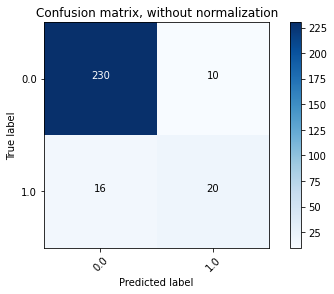

In [81]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.95833333 0.04166667]
 [0.44444444 0.55555556]]


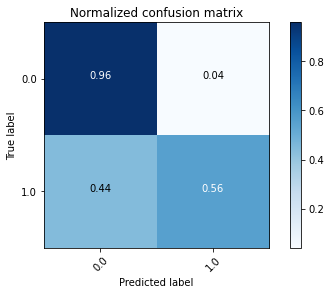

In [82]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()